In [65]:
import os
import io
import warnings
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

import matplotlib.pyplot as plt
%matplotlib inline

# Pretty looking cofigs
warnings.filterwarnings("ignore")

In [66]:
data = pd.read_csv("./data/data.csv")
data['Date'] = pd.to_datetime(data['Date'], format='%d-%b-%y')
exo = data[['Open', 'High', 'Low', 'Shares Traded']]
data = data[['Date', 'Close']]
data.index = data['Date']
data.drop(columns='Date', inplace=True)
data.sort_index(inplace=True)
data.head()

,Close
Date,
2011-01-03,6157.60
2011-01-04,6146.35
2011-01-05,6079.80
2011-01-06,6048.25
2011-01-07,5904.60


In [67]:
data.isna().sum()

Close    0
dtype: int64

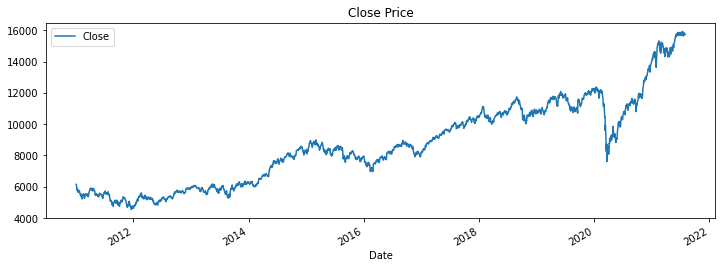

In [68]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Close Price')
plt.show(block=False)

#### Box Plot interquartile range

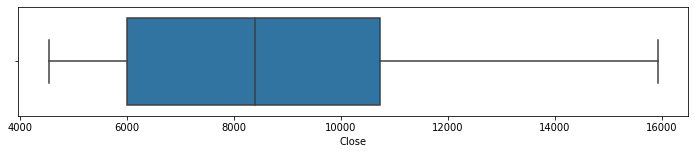

In [69]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=data['Close'],whis=1.5)

#### Histogram

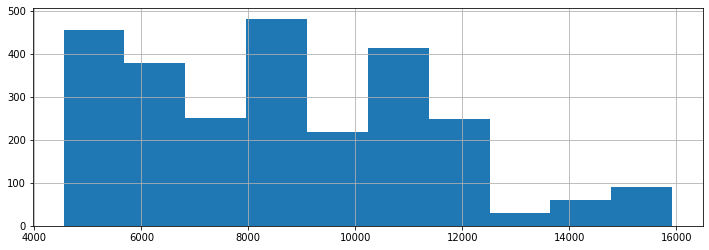

In [70]:
fig = data.Close.hist(figsize = (12,4))

#### Stationarity

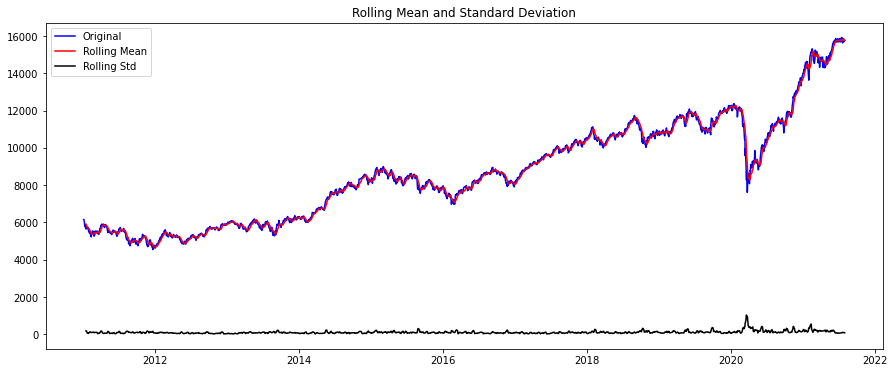

Results of dickey fuller test
Test Statistics                   0.367242
p-value                           0.980228
No. of lags used                 12.000000
Number of observations used    2608.000000
critical value (1%)              -3.432860
critical value (5%)              -2.862649
critical value (10%)             -2.567360
dtype: float64


In [71]:
#Test for staionarity
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(10).mean()
    rolstd = timeseries.rolling(10).std()
    #Plot rolling statistics:
    rcParams['figure.figsize'] = 15, 6
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(data)

The increasing mean and standard deviation may be seen in the graph above, indicating that our series isn’t stationary.<br/><br/>
We can’t rule out the Null hypothesis because the p-value is bigger than 0.05. Additionally, the test statistics exceed the critical values. As a result, the data is nonlinear.<br/>
Seasonality and trend may need to be separated from our series before we can undertake a time series analysis. This approach will cause the resulting series to become stagnant.

### Time Series Decomposition

#### Additive Seasonal Decomposition

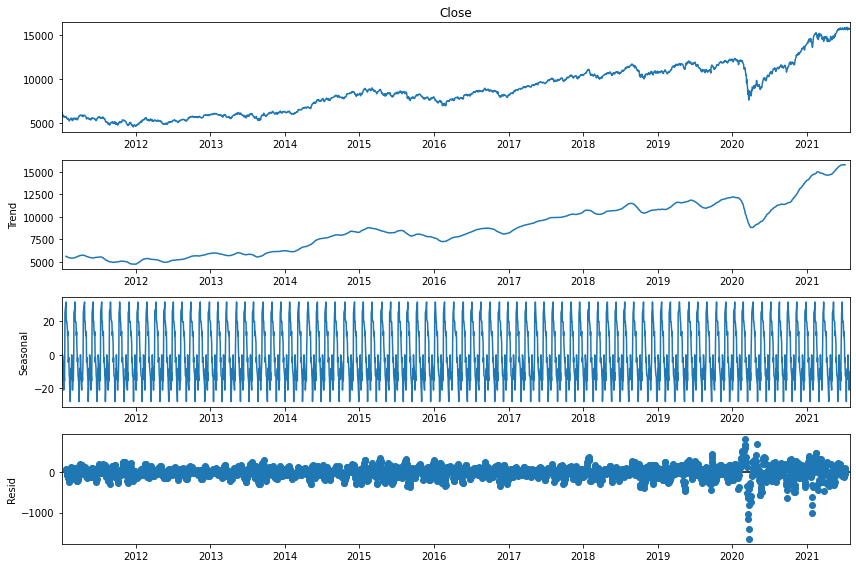

In [72]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data.Close, model='additive', freq=30) # additive seasonal index
fig = decomposition.plot()
plt.show()

#### Multiplicative Seasonal Decomposition

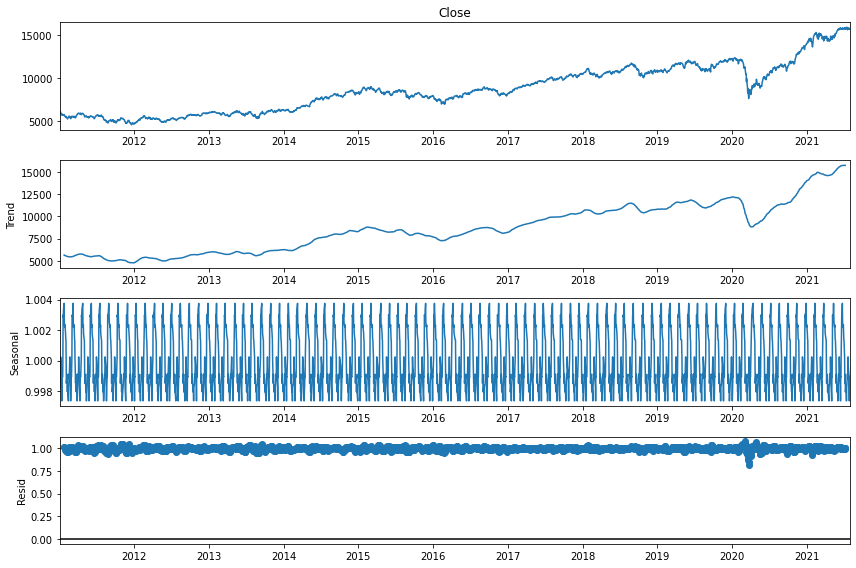

In [73]:
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data.Close, model='multiplicative', freq=30) # additive seasonal index
fig = decomposition.plot()
plt.show()

To reduce the magnitude of the values and the growing trend in the series, we first take a log of the series. We then calculate the rolling average of the series after obtaining the log of the series. A rolling average is computed by taking data from the previous 12 months and calculating a mean consumption value at each subsequent point in the series.

No handles with labels found to put in legend.


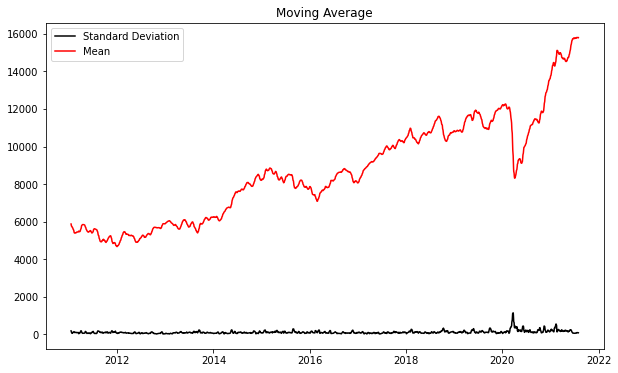

In [74]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
# df_log = np.log(data)
# exo = np.log(exo)
df_log = data
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

### ARIMA

Now we’ll develop an ARIMA model and train it using the stock’s closing price from the train data. So, let’s visualize the data by dividing it into training and test sets.

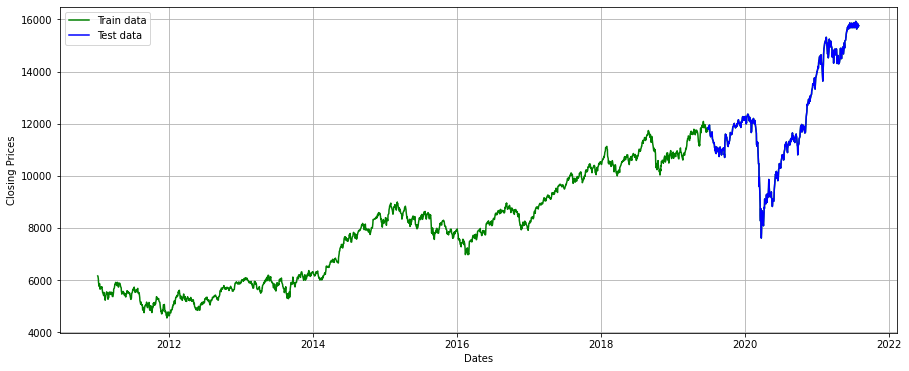

In [75]:
# Train-Test Split
# train_data, test_data = df_log[:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
train_data, test_data = df_log[:2100], df_log[2100:]
exo_train, exo_test = exo[:2100], exo[2100:]
plt.figure(figsize=(15,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23829.580, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23819.092, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=23818.977, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23830.621, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23820.976, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=23820.977, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=23823.000, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=23819.604, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.621 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2100
Model:               SARIMAX(0, 1, 1)   Log Likelihood              -11906.488
Date:                Wed, 08 Dec 2021   AIC                          23818.977
Time:                       

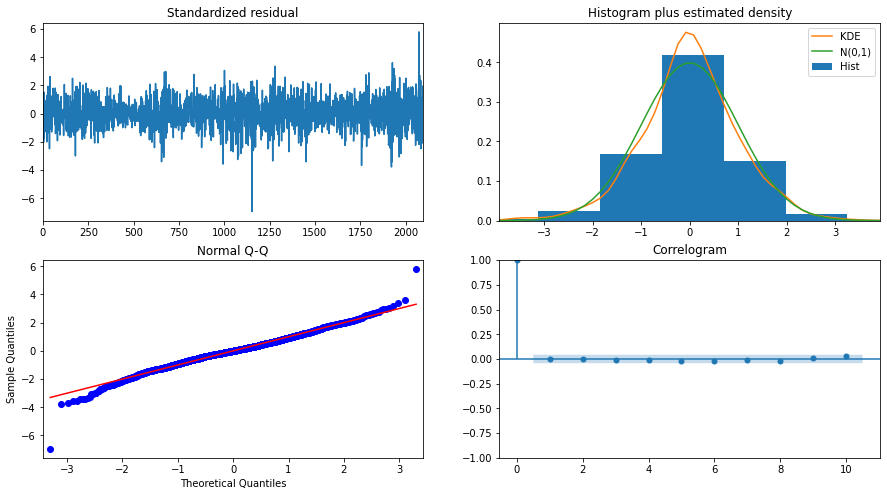

In [76]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

As a result, the Auto ARIMA model assigned the values 0, 1, and 1 to, p, d, and q, respectively.

<b>Top left:</b> The residual errors appear to have a uniform variance and fluctuate around a mean of zero.
<br/><br/>
<b>Top Right:</b> The density plot on the top right suggests a normal distribution with a mean of zero.
<br/><br/>
<b>Bottom left:</b> The red line should be perfectly aligned with all of the dots. Any significant deviations would indicate a skewed distribution.
<br/><br/>
<b>Bottom Right:</b> The residual errors are not autocorrelated, as shown by the Correlogram, also known as the ACF plot. Any autocorrelation would imply that the residual errors have a pattern that isn’t explained by the model. As a result, you’ll need to add more Xs (predictors) to the model.

In [77]:
model_autoARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2100
Model:               SARIMAX(0, 1, 1)   Log Likelihood              -11906.488
Date:                Wed, 08 Dec 2021   AIC                          23818.977
Time:                        14:39:35   BIC                          23835.924
Sample:                             0   HQIC                         23825.184
                               - 2100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.5497      1.667      1.529      0.126      -0.718       5.817
ma.L1          0.0777      0.019      4.089      0.000       0.040       0.115
sigma2      4946.2669    106.653     46.377      0.000    4737.231    5155.302
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               416.82
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
# Forecast
fc, conf = model_autoARIMA.predict(len(df_log[2100:]), return_conf_int=True, alpha=0.05)  # 95% conf

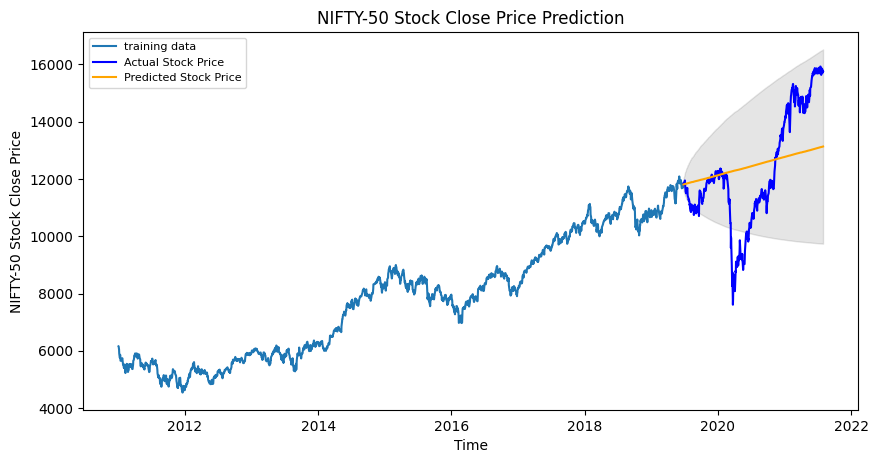

In [79]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('NIFTY-50 Stock Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('NIFTY-50 Stock Close Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [80]:
# report performance --- Close
fc = fc.reshape(len(fc),1)
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 3003730.6281781946
MAE: 1387.5576755583297
RMSE: 1733.1274125632526
MAPE: Close    0.118263
dtype: float64


In [81]:
# report performance --- LOG(Close)
fc = fc.reshape(len(fc),1)
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 3003730.6281781946
MAE: 1387.5576755583297
RMSE: 1733.1274125632526
MAPE: Close    0.118263
dtype: float64


In [82]:
np.log(rmse)

7.4576828083998

In [83]:
np.log(6685)

8.807621489536043

In [84]:
np.exp(8.807621489536043)

6684.999999999996

### SARIMA

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=inf, Time=21.57 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=23829.580, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=23819.019, Time=1.65 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=23818.902, Time=1.80 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=23830.621, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[30] intercept   : AIC=23818.977, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[30] intercept   : AIC=23820.875, Time=3.94 sec
 ARIMA(0,1,1)(0,0,2)[30] intercept   : AIC=23820.825, Time=10.14 sec
 ARIMA(0,1,1)(1,0,0)[30] intercept   : AIC=23818.923, Time=1.37 sec
 ARIMA(0,1,1)(1,0,2)[30] intercept   : AIC=23822.842, Time=11.59 sec
 ARIMA(0,1,0)(0,0,1)[30] intercept   : AIC=23829.403, Time=2.99 sec
 ARIMA(1,1,1)(0,0,1)[30] intercept   : AIC=23820.899, Time=3.93 sec
 ARIMA(0,1,2)(0,0,1)[30] intercept   : AIC=23820.899, Time=2.92 sec
 ARIMA(1,1,0)(0,0,1)[30] intercept   : AIC=23818.989, Time=1.78 sec
 ARIMA(1

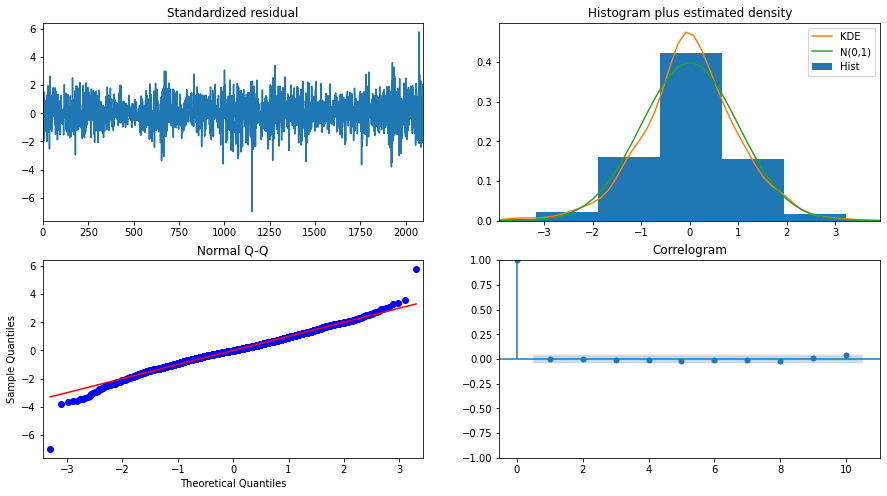

In [21]:
model_autoSARIMA = auto_arima(train_data,
                      test='adf',       # use adftest to find optimal 'd'
                      m = 30,
                      seasonal=True,    # With Seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True, n_jobs=-1)
print(model_autoSARIMA.summary())
model_autoSARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

SARIMA -- auto_arima is suggesting Best model:  ARIMA(0,1,1)(1,0,1)[30] intercept

In [28]:
model_autoSARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2100
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 30)   Log Likelihood              -11905.451
Date:                            Wed, 08 Dec 2021   AIC                          23818.902
Time:                                    14:32:53   BIC                          23841.499
Sample:                                         0   HQIC                         23827.179
                                           - 2100                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.5498      1.721      1.482      0.138      -0.823       5.923
ma.L1          0.0773      0.019      4.059      0.000       0.040       0.115
ma.S.L30       0.0324      0.022      1.478      0.139      -0.011       0.075
sigma2      4946.2591    106.802     46.312      0.000    4736.931    5155.587
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               427.39
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
# Forecast
fc, conf = model_autoSARIMA.predict(test_data.shape[0], return_conf_int=True, alpha=0.05)  # 95% conf

In [30]:
fc.shape

(521,)

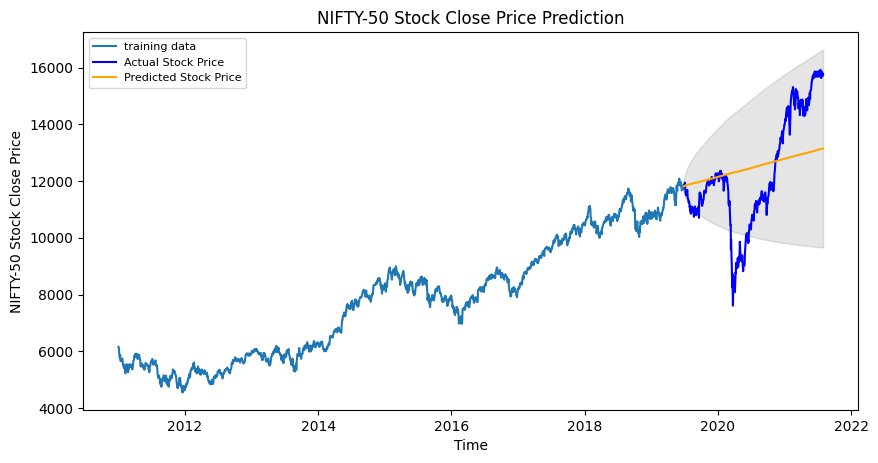

In [31]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('NIFTY-50 Stock Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('NIFTY-50 Stock Close Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [32]:
# report performance --- Close
fc = fc.reshape(len(fc),1)
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 3009964.6329307444
MAE: 1391.5979358089453
RMSE: 1734.924964639896
MAPE: Close    0.118803
dtype: float64


### SARIMAX

In [85]:
exo_train

,Open,High,Low,Shares Traded
0,6177.45,6178.55,6147.20,96028639
1,6172.75,6181.05,6124.40,181727905
2,6141.35,6141.35,6062.35,139614193
3,6107.00,6116.15,6022.30,152338978
4,6030.90,6051.20,5883.60,171809106
...,...,...,...,...
2095,11744.45,11802.50,11625.10,446933027
2096,11653.65,11843.50,11635.05,442016954
2097,11827.60,11827.95,11705.10,468430388
2098,11725.80,11754.00,11670.20,277620788


In [86]:
# 5 Days lag
for _ in range(5):
    exo_train = exo_train.shift(-1)
    exo_train[-1:] = 0
exo_train

,Open,High,Low,Shares Traded
0,5901.30,5907.25,5740.95,156945855.0
1,5767.95,5842.60,5698.20,161261704.0
2,5800.05,5874.20,5711.30,188116995.0
3,5850.75,5857.75,5736.70,175347539.0
4,5752.10,5833.65,5639.65,174568442.0
...,...,...,...,...
2095,0.00,0.00,0.00,0.0
2096,0.00,0.00,0.00,0.0
2097,0.00,0.00,0.00,0.0
2098,0.00,0.00,0.00,0.0


In [87]:
exo_train.tail(7)

,Open,High,Low,Shares Traded
2093,11725.8,11754.0,11670.2,277620788.0
2094,11681.0,11814.4,11651.0,300476353.0
2095,0.0,0.0,0.0,0.0
2096,0.0,0.0,0.0,0.0
2097,0.0,0.0,0.0,0.0
2098,0.0,0.0,0.0,0.0
2099,0.0,0.0,0.0,0.0


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=24565.860, Time=12.13 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=23836.542, Time=0.37 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=23826.055, Time=8.36 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=23826.054, Time=7.92 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=37795.295, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[30] intercept   : AIC=23825.832, Time=0.47 sec
 ARIMA(0,1,1)(1,0,0)[30] intercept   : AIC=23825.931, Time=7.60 sec
 ARIMA(0,1,1)(1,0,1)[30] intercept   : AIC=23828.079, Time=8.96 sec
 ARIMA(1,1,1)(0,0,0)[30] intercept   : AIC=23827.833, Time=0.55 sec
 ARIMA(0,1,2)(0,0,0)[30] intercept   : AIC=23827.854, Time=0.61 sec
 ARIMA(1,1,0)(0,0,0)[30] intercept   : AIC=23825.975, Time=0.42 sec
 ARIMA(1,1,2)(0,0,0)[30] intercept   : AIC=23842.644, Time=0.69 sec
 ARIMA(0,1,1)(0,0,0)[30]             : AIC=23826.463, Time=1.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[30] intercept
Total fit time: 49.415 s

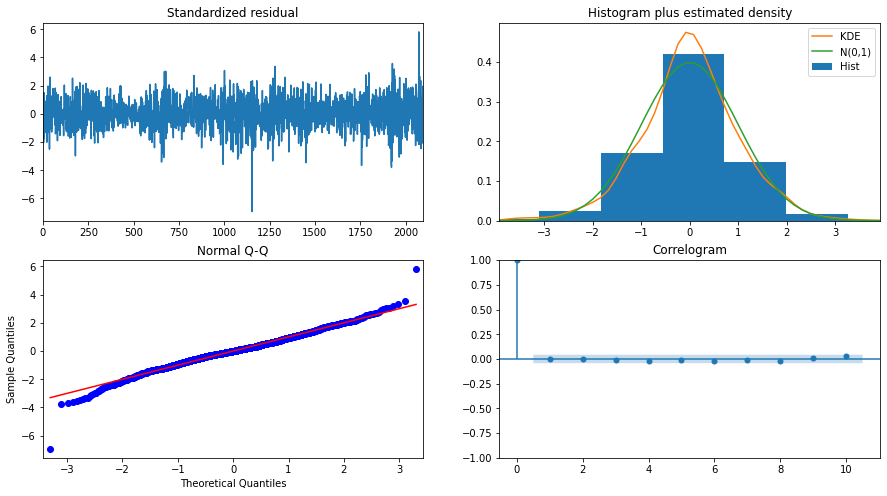

In [88]:
model_autoSARIMAX = auto_arima(train_data,
                      test='adf',       # use adftest to find optimal 'd'
                      m = 30,
                      seasonal=True,    # With Seasonality
                      X = exo_train,    # Exogenous Variables\
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True, n_jobs=-1)
print(model_autoSARIMAX.summary())
model_autoSARIMAX.plot_diagnostics(figsize=(15,8))
plt.show()

For SARIMAX auto_arima is suggesting Best model: ARIMA(1,0,0)(0,0,0)[30]  intercept

In [89]:
# Forecast
fc, conf = model_autoSARIMAX.predict(len(df_log[2100:]), X=exo_test, return_conf_int=True, alpha=0.05)  # 95% conf

In [90]:
fc.shape

(521,)

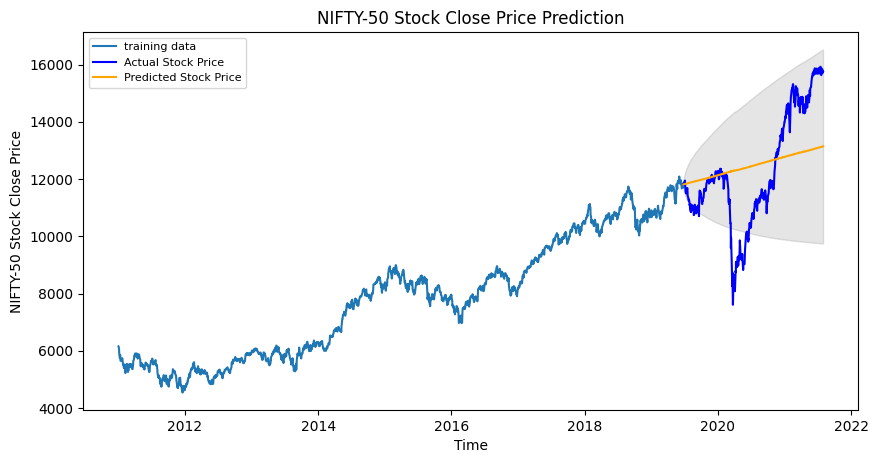

In [91]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('NIFTY-50 Stock Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('NIFTY-50 Stock Close Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [92]:
# report performance --- Close
fc = fc.reshape(len(fc),1)
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 3002241.47240044
MAE: 1387.6582937449075
RMSE: 1732.6977440974638
MAPE: Close    0.118351
dtype: float64
